

> 
* Ahmed Sherif abd elhamed elhoussany ( X1706 )
* Asaad Mohamed Ibrahim Zaid          ( X2448 )
* Alaa Ahmed Elshafie                 ( X1549 )
* Eman Fawzy Mohamed Ali              ( X2103 )
* Ayad Amin Ahmad Al Far (X1543)
* Mohammed Ahmed Abdulwahab Mohammed (X1925)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
# !cd /content/drive/MyDrive/Car & Bike

# Structure file in my google drive
%cd "/content/drive/MyDrive/Colab Notebooks/Car vs Bike"

/content/drive/MyDrive/Colab Notebooks/Car vs Bike


In [ ]:
# !unzip "/content/drive/MyDrive/Car & Bike/Car vs Bike.zip"

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras
from keras_preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [ ]:
input_path = []  # to save path of image
label = []       # to save label of image

# loop through folder "Car & Bike"
for class_name in os.listdir("Car-Bike-Dataset"):
  # loop through the cuurent path
    for path in os.listdir("Car-Bike-Dataset/"+class_name):
        if class_name == 'Bike': label.append(0)
        else: label.append(1)
        input_path.append(os.path.join("Car-Bike-Dataset", class_name, path))
        
print(input_path[0], label[0])

Car-Bike-Dataset/Bike/Bike (321).jpeg 0


In [ ]:
df = pd.DataFrame({'images': input_path, 'label': label})
del input_path, label
df

images  label
0     Car-Bike-Dataset/Bike/Bike (321).jpeg      0
1       Car-Bike-Dataset/Bike/Bike (34).jpg      0
2        Car-Bike-Dataset/Bike/Bike (3).jpg      0
3     Car-Bike-Dataset/Bike/Bike (346).jpeg      0
4     Car-Bike-Dataset/Bike/Bike (405).jpeg      0
...                                     ...    ...
3995    Car-Bike-Dataset/Car/Car (533).jpeg      1
3996   Car-Bike-Dataset/Car/Car (1568).jpeg      1
3997    Car-Bike-Dataset/Car/Car (424).jpeg      1
3998   Car-Bike-Dataset/Car/Car (1564).jpeg      1
3999    Car-Bike-Dataset/Car/Car (160).jpeg      1

[4000 rows x 2 columns]

In [ ]:
# build helper function to display grid of images
def show_imgs(imgs:list, title=None, nrows=5, ncols=5, figsize=(20, 20)):

  plt.figure(figsize=figsize)

  for index, img in enumerate(imgs):
    plt.subplot(nrows, ncols, index+1)

    if isinstance(imgs[0], str):
      img = np.array(load_img(img))

    plt.imshow(img)
    plt.axis('off')

    if type(title) is not None:
      if isinstance(title, str):
        plt.title(title)
      elif isinstance(title, np.ndarray) or isinstance(title, list):
        plt.title(title[index])

  plt.show()

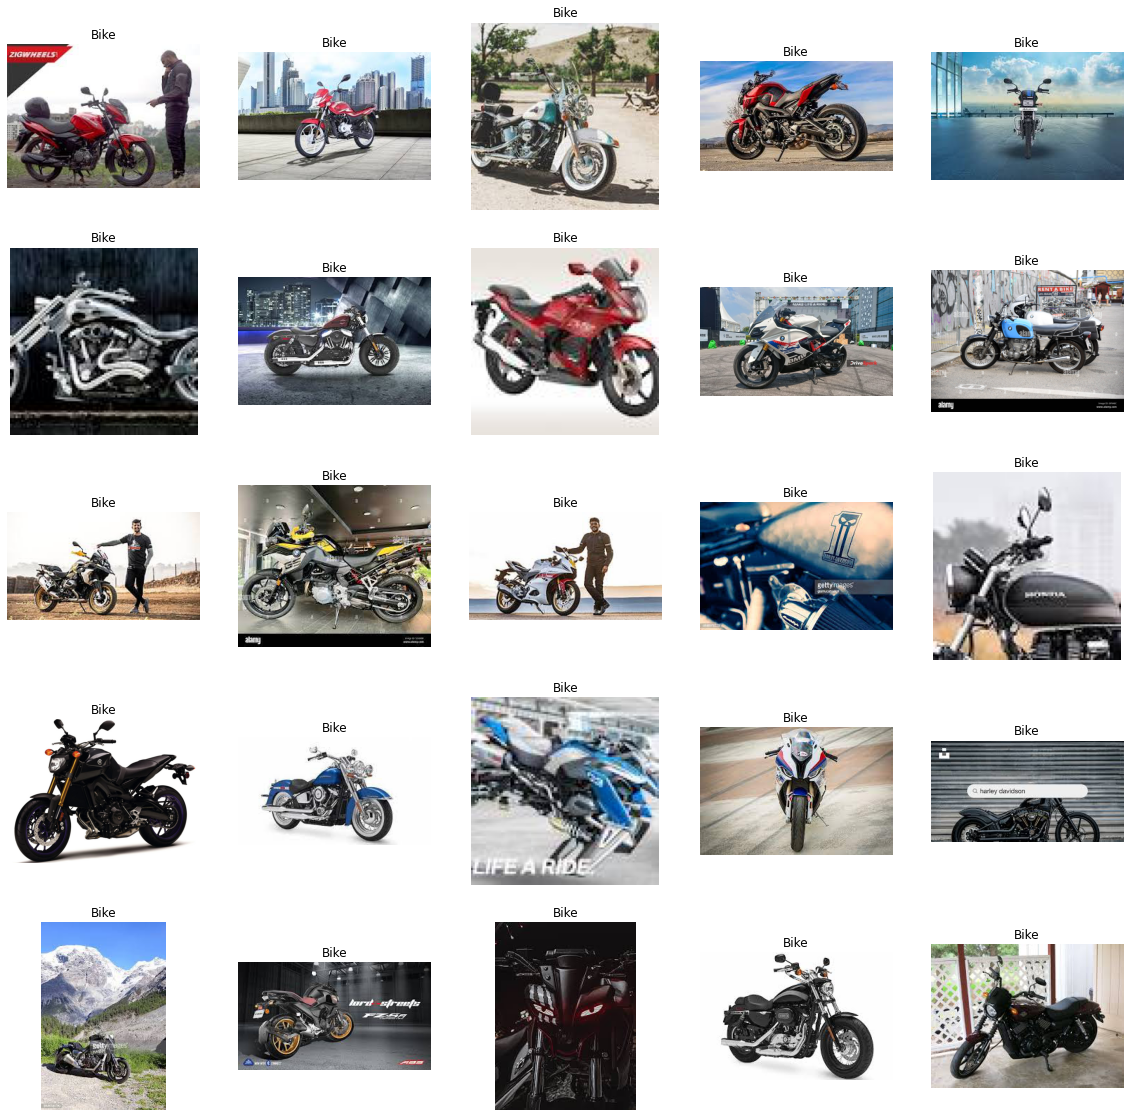

In [ ]:
# get random indices of bike images 
bike_idx = np.random.choice(np.where(df['label'] == 0)[0], 25)

show_imgs(imgs=df['images'].iloc[bike_idx].values, title='Bike')

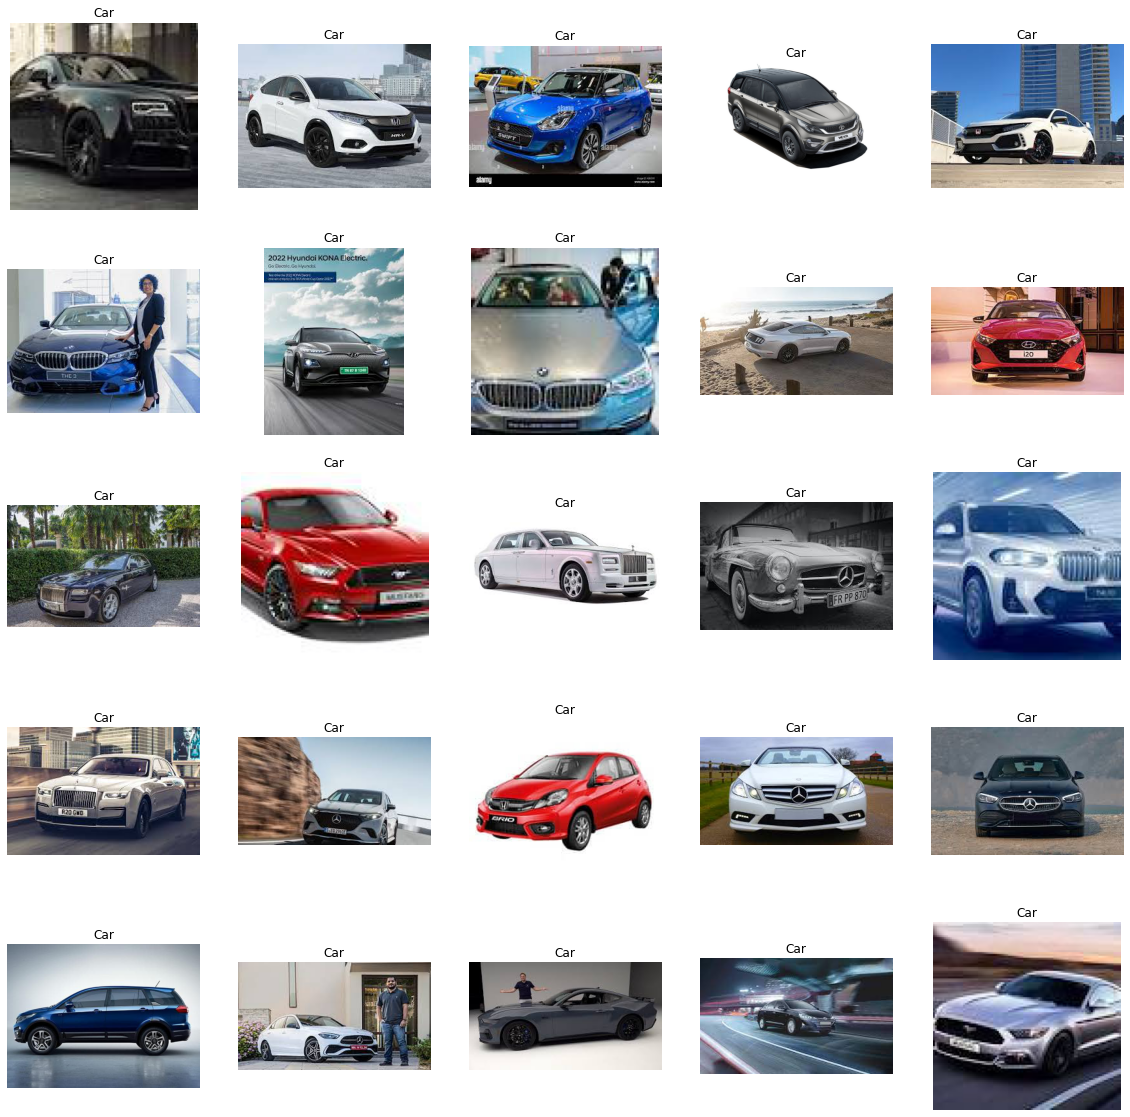

In [ ]:
# to display grid of images
# get random indices of Car images 
car_idx = np.random.choice(np.where(df['label']==1)[0], 25)

show_imgs(imgs=df['images'].iloc[car_idx].values, title='Car')

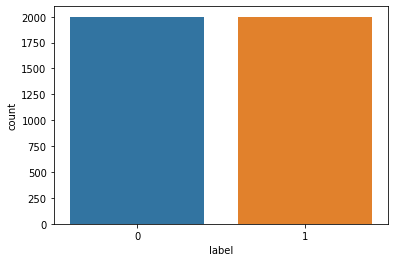

In [ ]:
import seaborn as sns

sns.countplot(df['label'])
plt.show()

In [ ]:
df['label'].value_counts()

0    2000
1    2000
Name: label, dtype: int64

In [ ]:
df['label'] = df['label'].astype(int)
df.head()

images  label
0  Car-Bike-Dataset/Bike/Bike (321).jpeg      0
1    Car-Bike-Dataset/Bike/Bike (34).jpg      0
2     Car-Bike-Dataset/Bike/Bike (3).jpg      0
3  Car-Bike-Dataset/Bike/Bike (346).jpeg      0
4  Car-Bike-Dataset/Bike/Bike (405).jpeg      0

In [ ]:
# Load Images
img_shape = (224, 224, 3)

def imread(imgpath):
  img = cv2.imread(imgpath)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (img_shape[0], img_shape[1]))
  return img

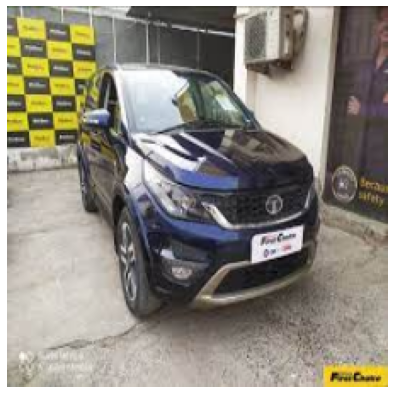

In [ ]:
img = imread(df['images'].values[3692])

show_imgs([img], nrows=1, ncols=1, figsize=(7,7))

In [ ]:
# enhance detail of the given image
# sigma_s => range[0 to 200]
# sigma_r => range[0 to 1]
def enhance_detail(img, sigma_s=100, sigma_r=0.6):
  enh_img = cv2.detailEnhance(img, sigma_s=sigma_s, sigma_r=sigma_r)
  return enh_img

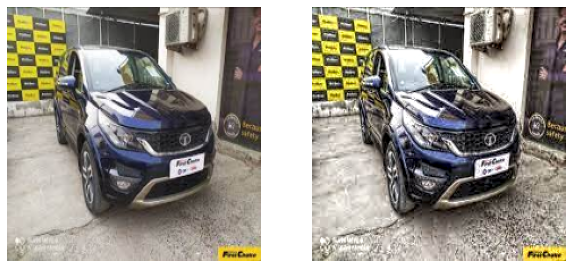

In [ ]:
enhanced_img = enhance_detail(img, sigma_s=60, sigma_r=0.05)

show_imgs([img, enhanced_img], nrows=1, ncols=2, figsize=(10,15))

In [ ]:
data_imgs = np.array([imread(img) for img in df['images'].values])
data_labels = np.array(df['label'].values)

del df

In [ ]:
data_imgs.shape, data_labels.shape

((4000, 224, 224, 3), (4000,))

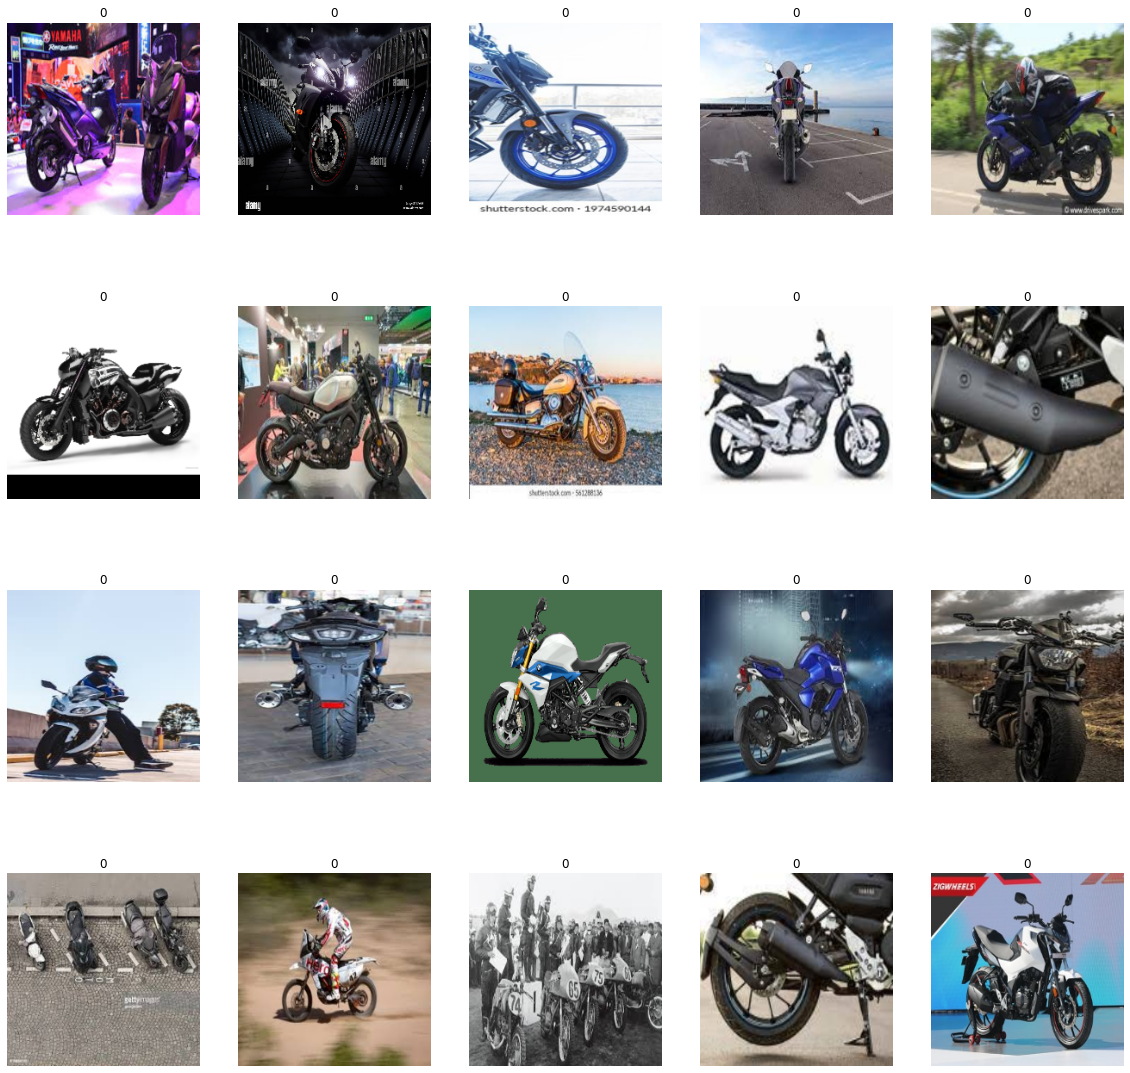

In [ ]:
show_imgs(data_imgs[:20], title=data_labels[:20], nrows=4, ncols=5)

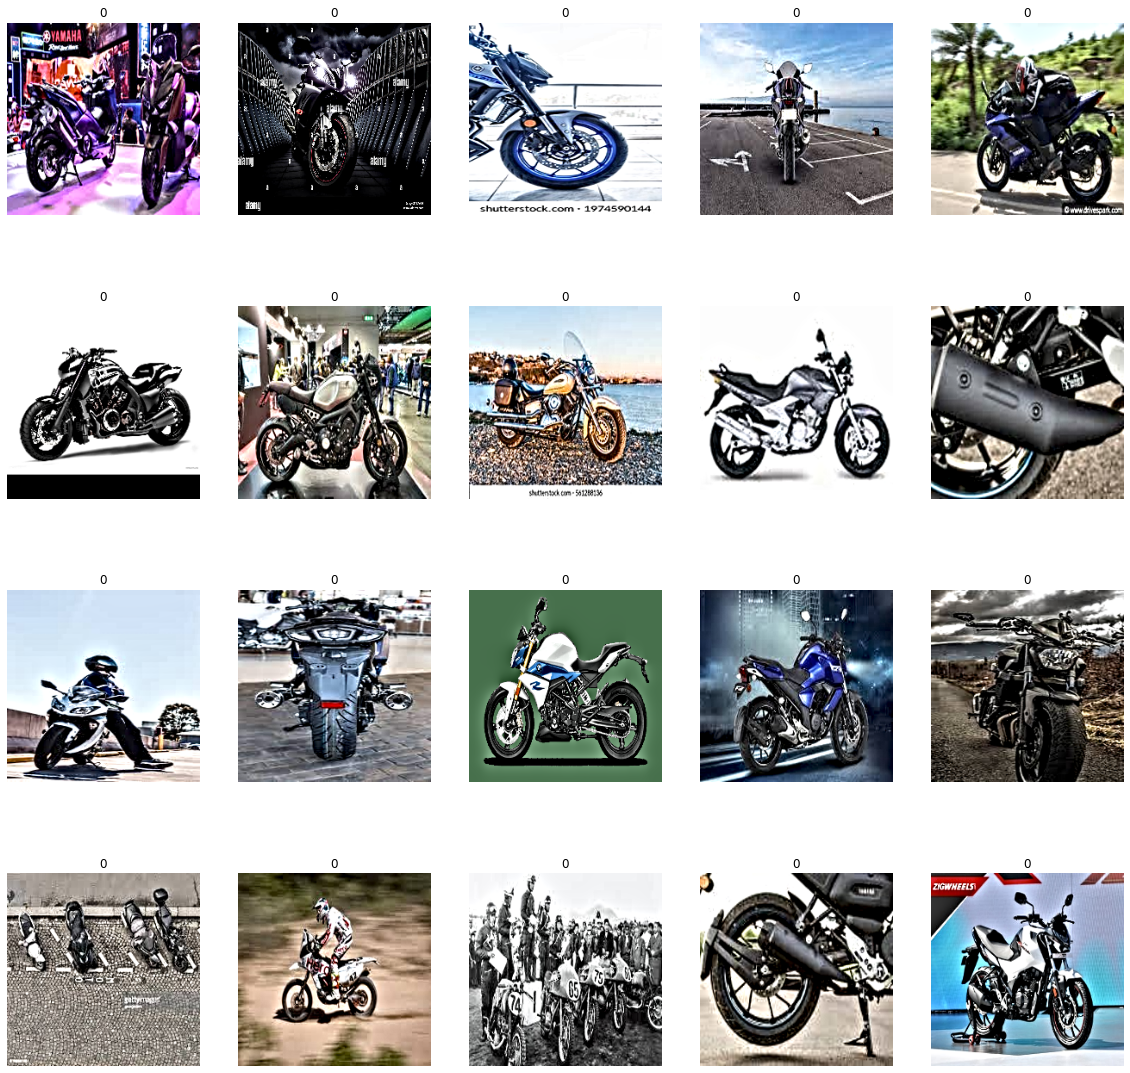

In [ ]:
data_imgs = np.array([enhance_detail(img, sigma_s=10, sigma_r=0.2) for img in data_imgs])

show_imgs(data_imgs[:20], title=data_labels[:20], nrows=4, ncols=5)

Data Spliting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_imgs, data_labels, test_size=0.2, shuffle=True)

del data_imgs, data_labels

In [ ]:
(X_train.shape, y_train.shape), ( X_test.shape, y_test.shape)

(((3200, 224, 224, 3), (3200,)), ((800, 224, 224, 3), (800,)))

In [ ]:
train_generator = ImageDataGenerator(
    brightness_range=[0.1, 0.9],
    rescale = 1./255,    # normalization of images
    rotation_range = 20, # amount of rotation
    shear_range = 0.2,   # shear angle in counter-clockwise direction as radians
    zoom_range = 0.2,    # range for random zoom
    horizontal_flip = True,
    fill_mode = 'nearest'  # One of {“constant”, “nearest”, “reflect” or “wrap”}. Points outside the boundaries of the input are filled according to the given mode
    # validation_split=0.20
 )

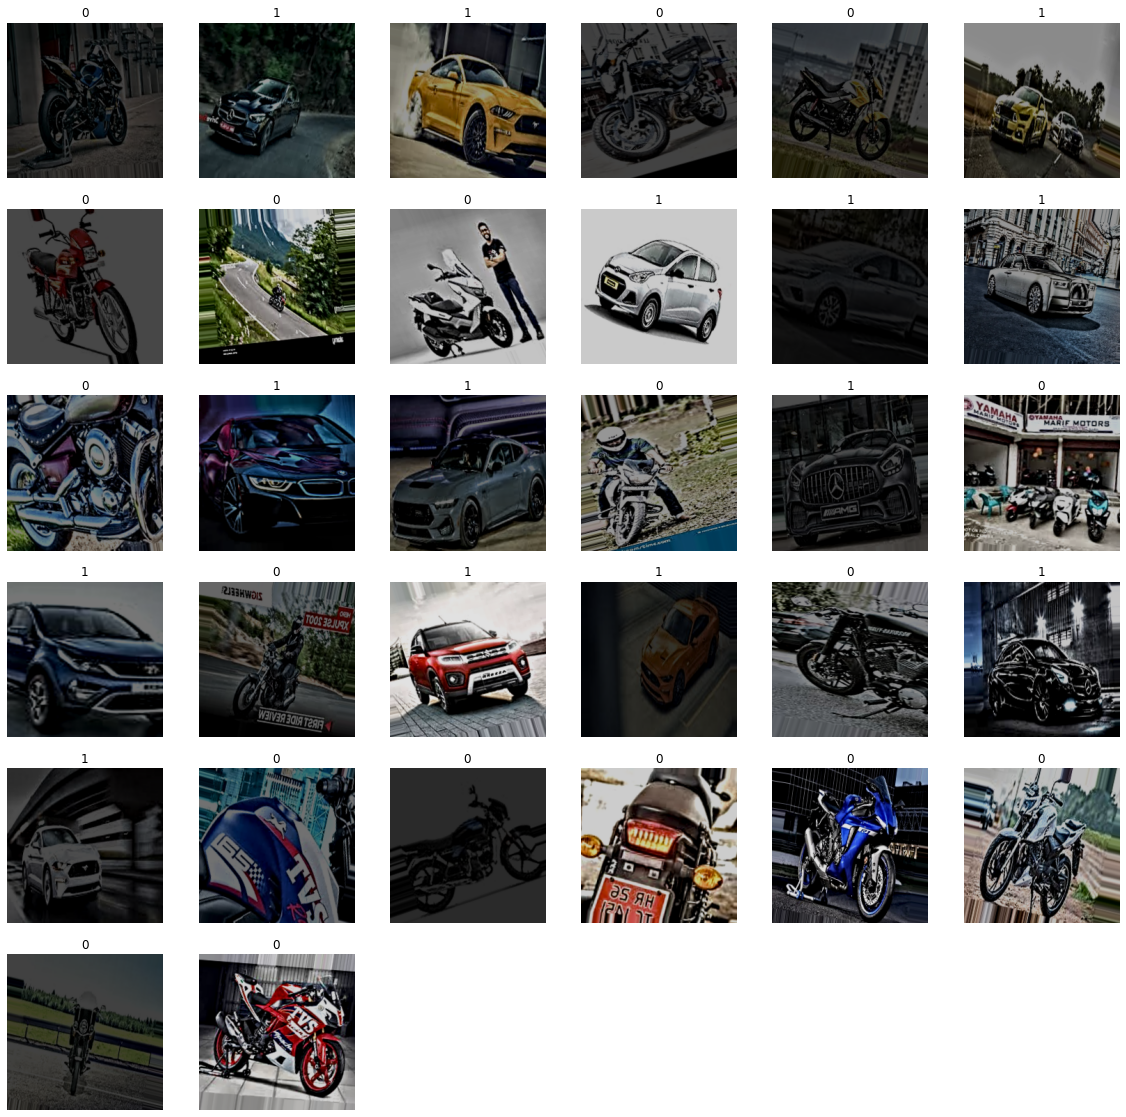

In [ ]:
batch = train_generator.flow(X_train, y_train, batch_size=32).next()
show_imgs(batch[0], batch[1], nrows=6, ncols=6)

In [ ]:
no_classes = 1
classifire_activation = "sigmoid"
optimizer = "adam"
loss_func = "binary_crossentropy"

In [ ]:
model1 = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', input_shape=img_shape),    
    MaxPool2D(pool_size=(2,2)),

    Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu'),    
    MaxPool2D(pool_size=(2,2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'),    
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'),    
    MaxPool2D(pool_size=(3,3), strides=(2,2)),

    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(.5),
    Dense(units=256, activation='relu'),
    Dropout(.5),
    Dense(units=no_classes, activation=classifire_activation)
]) 

model1.compile(optimizer=optimizer, loss=loss_func, metrics=["accuracy"])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 128)      0

In [ ]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy', verbose=2, factor=0.5, min_lr=0.00001)
model_check=ModelCheckpoint('model1.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [ ]:
val_s=500
history = model1.fit(train_generator.flow(X_train[val_s:], y_train[val_s:], batch_size=32),
                     validation_data=train_generator.flow(X_train[:val_s], y_train[:val_s], batch_size=8), 
                     epochs=10, callbacks=[callback], verbose=2)

Epoch 1/10

Epoch 1: val_loss improved from 0.16767 to 0.16106, saving model to model1.hdf5
85/85 - 36s - loss: 0.1581 - accuracy: 0.9430 - val_loss: 0.1611 - val_accuracy: 0.9380 - lr: 0.0010 - 36s/epoch - 418ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.16106 to 0.14875, saving model to model1.hdf5
85/85 - 35s - loss: 0.1825 - accuracy: 0.9281 - val_loss: 0.1487 - val_accuracy: 0.9440 - lr: 0.0010 - 35s/epoch - 417ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.14875 to 0.13968, saving model to model1.hdf5
85/85 - 36s - loss: 0.1601 - accuracy: 0.9400 - val_loss: 0.1397 - val_accuracy: 0.9440 - lr: 0.0010 - 36s/epoch - 426ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.13968
85/85 - 34s - loss: 0.1439 - accuracy: 0.9493 - val_loss: 0.2410 - val_accuracy: 0.9200 - lr: 0.0010 - 34s/epoch - 405ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.13968
85/85 - 34s - loss: 0.1680 - accuracy: 0.9337 - val_loss: 0.2466 - val_accuracy: 0.8880 - lr: 0.0010 -

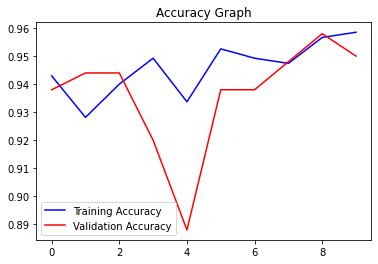

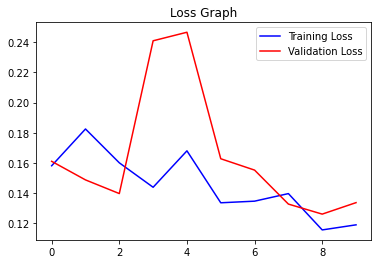

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
model1.evaluate(X_test/255.0, y_test)

25/25 [==============================] - 1s 21ms/step - loss: 0.1042 - accuracy: 0.9625


[0.10424169898033142, 0.9624999761581421]

In [ ]:
predictions = model1.predict(X_test/255.0, verbose=1)

25/25 [==============================] - 1s 20ms/step


In [ ]:
predictions[:10]

array([[7.1195089e-08],
       [2.4930644e-04],
       [1.2672102e-01],
       [9.9999356e-01],
       [1.0000000e+00],
       [9.9715388e-01],
       [1.0000000e+00],
       [9.9999988e-01],
       [4.4334520e-05],
       [6.6798534e-03]], dtype=float32)

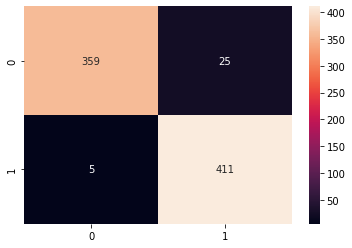

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.float32(y_test), predictions.round())
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
print(classification_report(np.float32(y_test), predictions.round()))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       384
         1.0       0.94      0.99      0.96       416

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



In [ ]:
del model1, history, predictions

**Try With Transfer Learning**

In [ ]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
# VGG16 Model
vgg16_model = VGG16(
    input_shape=img_shape, 
    weights='imagenet', 
    include_top=False
)

# don't train existing weights
for layer in vgg16_model.layers:
    layer.trainable = False

# our layers you can add more if you want
x = Flatten()(vgg16_model.output)

# x = Dense(2024, activation='relu')(x)
classifier = Dense(units=no_classes, activation=classifire_activation)(x)

# create a model object
vgg16_model = keras.models.Model(inputs=vgg16_model.input, outputs=classifier)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def processing(img):
  img_ = preprocess_input(img)
  img_ = tf.convert_to_tensor(img_)
  return img_

In [ ]:
X_train = tf.convert_to_tensor([processing(im) for im in X_train])
y_train = tf.convert_to_tensor(y_train)

In [ ]:
EarlyStop = EarlyStopping(patience=3, restore_best_weights=True)
Reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', verbose=2, factor=0.5, min_lr=0.00001)
model_check = ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
callback_list = [EarlyStop, Reduce_LR, model_check]

In [ ]:
history = vgg16_model.fit(train_generator.flow(X_train[val_s:], y_train[val_s:], batch_size=32),
         validation_data=train_generator.flow(X_train[:val_s], y_train[:val_s], batch_size=8),
         epochs=10,  callbacks=[callback_list], verbose=2)

Epoch 1/10

Epoch 1: val_loss improved from 0.13044 to 0.10632, saving model to model.hdf5
85/85 - 42s - loss: 0.1204 - accuracy: 0.9548 - val_loss: 0.1063 - val_accuracy: 0.9600 - lr: 0.0010 - 42s/epoch - 495ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.10632 to 0.10414, saving model to model.hdf5
85/85 - 42s - loss: 0.1032 - accuracy: 0.9637 - val_loss: 0.1041 - val_accuracy: 0.9560 - lr: 0.0010 - 42s/epoch - 489ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.10414 to 0.07200, saving model to model.hdf5
85/85 - 41s - loss: 0.0888 - accuracy: 0.9681 - val_loss: 0.0720 - val_accuracy: 0.9800 - lr: 0.0010 - 41s/epoch - 477ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.07200
85/85 - 40s - loss: 0.0852 - accuracy: 0.9719 - val_loss: 0.0947 - val_accuracy: 0.9700 - lr: 0.0010 - 40s/epoch - 472ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.07200
85/85 - 39s - loss: 0.0826 - accuracy: 0.9644 - val_loss: 0.1219 - val_accuracy: 0.9460 - lr: 0.0010 - 39

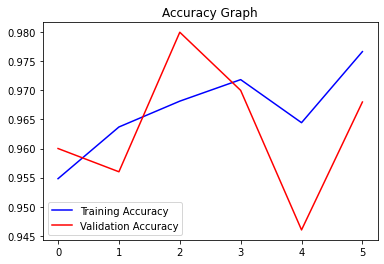

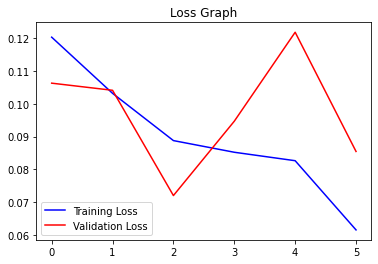

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
X_test = tf.convert_to_tensor([processing (im) for im in X_test])
y_test = tf.convert_to_tensor(y_test)

In [ ]:
vgg16_model.evaluate(X_test, y_test)

25/25 [==============================] - 4s 145ms/step - loss: 1.0476 - accuracy: 0.9800


[1.0476070642471313, 0.9800000190734863]

In [ ]:
predictions = vgg16_model.predict(X_test/255.0, verbose=1)

25/25 [==============================] - 4s 153ms/step


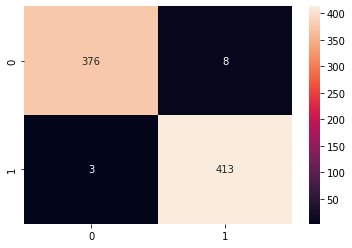

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.float32(y_test), predictions.round())
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
print(classification_report(np.float32(y_test), predictions.round()))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       384
         1.0       0.98      0.99      0.99       416

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

